In [71]:
import sys
sys.path.append("../")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
from datetime import datetime, timedelta, timezone
import zoneinfo

import polars as pl
import talib
import numpy as np
from matplotlib import markers as mpl_markers
import matplotlib.pyplot as plt
import pandas as pd

from src.data.index import CandlesAssetData

# Data

In [73]:
asset = CandlesAssetData.from_polars((
    pl.read_parquet("../tests/static/T.parquet")
    .filter(pl.col("ts") >= datetime(2025, 1, 25, 0, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='UTC')))
    .filter(pl.col("ts") <= datetime(2025, 2, 1, 0, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='UTC')))
))

len(asset)

6830

# Talib

In [74]:
from src.features.talib import TALibFeaturizer


sma_periods = (15, 30, 60, 120)
for period in sma_periods:
    featurizer = TALibFeaturizer(f"sma_{period}", func=lambda kwargs: talib.SMA(real=kwargs["open"], timeperiod=period), add_to_asset=True)
    featurizer.get_features_batch(asset)

featurizer = TALibFeaturizer("rsi", func=lambda kwargs: talib.RSI(real=kwargs["open"], timeperiod=30), add_to_asset=True)
_ = featurizer.get_features_batch(asset)

6830it [00:00, 3387783.39it/s]
6830it [00:00, 1006008.44it/s]
6830it [00:00, 4336526.84it/s]
6830it [00:00, 3796831.85it/s]
6830it [00:00, 4285279.93it/s]


# Lag

In [75]:
from src.features.lag import LagTicksFeaturizer


for period in sma_periods:
    featurizer = LagTicksFeaturizer(f"sma_{period}_lag_5", feature=f"sma_{period}", lag=5, add_to_asset=True)
    featurizer.get_features_batch(asset)

lags = (1, 5, 15)
for lag in lags:
    featurizer = LagTicksFeaturizer(f"close_lag_{lag}", feature=f"close", lag=lag, add_to_asset=True)
    featurizer.get_features_batch(asset)

    featurizer = LagTicksFeaturizer(f"volume_lag_{lag}", feature="volume", lag=lag, add_to_asset=True)
    _ = featurizer.get_features_batch(asset)

# Func

In [76]:
from functools import partial

from src.features.func import FuncFeaturizer

In [77]:
def diff_cols(asset, dt, col1, col2):
    data = asset.get(dt)

    if data is None:
        return None

    if data[col1] is None:
        return None

    if data[col2] is None:
        return None

    return data[col1] - data[col2]


for period in sma_periods:
    col1 = f"sma_{period}"
    col2 = f"sma_{period}_lag_5"
    
    featurizer = FuncFeaturizer(f"diff_{col1}_{col2}", partial(diff_cols, col1=col1, col2=col2), add_to_asset=True)
    _ = featurizer.get_features_batch(asset)

for col in ("volume", "close"):
    col1 = f"{col}_lag_5"
    col2 = f"{col}_lag_1"
    
    featurizer = FuncFeaturizer(f"diff_{col1}_{col2}", partial(diff_cols, col1=col1, col2=col2), add_to_asset=True)
    _ = featurizer.get_features_batch(asset)

asset.to_polars()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6830/6830 [00:00<00:00, 164197.79it/s]


open,high,low,close,volume,ts,instrument_id,parse_ts,lot,sma_15,sma_30,sma_60,sma_120,rsi,sma_15_lag_5,sma_30_lag_5,sma_60_lag_5,sma_120_lag_5,close_lag_1,volume_lag_1,close_lag_5,volume_lag_5,close_lag_15,volume_lag_15,diff_sma_15_sma_15_lag_5,diff_sma_30_sma_30_lag_5,diff_sma_60_sma_60_lag_5,diff_sma_120_sma_120_lag_5,diff_volume_lag_5_volume_lag_1,diff_close_lag_5_close_lag_1
f64,f64,f64,f64,i64,"datetime[μs, UTC]",str,datetime[μs],i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,i64,f64,i64,f64,f64,f64,f64,i64,f64
3012.4,3012.4,3012.4,3012.4,3,2025-01-25 00:02:00 UTC,"""87db07bc-0e02-4e29-90bb-05e8ef…",2025-02-03 22:04:28.851341,1,NaN,NaN,NaN,NaN,NaN,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3012.4,3012.4,3012.4,3012.4,5,2025-01-25 00:04:00 UTC,"""87db07bc-0e02-4e29-90bb-05e8ef…",2025-02-03 22:04:28.851341,1,NaN,NaN,NaN,NaN,NaN,null,null,null,null,3012.4,3,null,null,null,null,null,null,null,null,null,null
3010.0,3010.0,3010.0,3010.0,1,2025-01-25 00:05:00 UTC,"""87db07bc-0e02-4e29-90bb-05e8ef…",2025-02-03 22:04:28.851341,1,NaN,NaN,NaN,NaN,NaN,null,null,null,null,3012.4,5,null,null,null,null,null,null,null,null,null,null
3012.4,3012.6,3012.4,3012.6,7,2025-01-25 00:06:00 UTC,"""87db07bc-0e02-4e29-90bb-05e8ef…",2025-02-03 22:04:28.851341,1,NaN,NaN,NaN,NaN,NaN,null,null,null,null,3010.0,1,null,null,null,null,null,null,null,null,null,null
3012.6,3012.6,3012.6,3012.6,5,2025-01-25 00:08:00 UTC,"""87db07bc-0e02-4e29-90bb-05e8ef…",2025-02-03 22:04:28.851341,1,NaN,NaN,NaN,NaN,NaN,null,null,null,null,3012.6,7,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
3053.6,3053.8,3053.6,3053.8,11,2025-01-31 23:52:00 UTC,"""87db07bc-0e02-4e29-90bb-05e8ef…",2025-02-03 22:04:28.851341,1,3053.64,3052.993333,3050.5,3045.963333,56.941962,3053.533333,3053.06,3049.446667,3045.59,3053.8,20,3053.4,14,3052.4,1,0.106667,-0.066667,1.053333,0.373333,-6,-0.4
3053.6,3053.8,3053.6,3053.8,34,2025-01-31 23:53:00 UTC,"""87db07bc-0e02-4e29-90bb-05e8ef…",2025-02-03 22:04:28.851341,1,3053.693333,3053.013333,3050.723333,3046.043333,56.941962,3053.546667,3052.98,3049.663333,3045.65,3053.8,11,3053.4,16,3052.2,35,0.146667,0.033333,1.06,0.393333,5,-0.4
3053.8,3053.8,3053.8,3053.8,47,2025-01-31 23:54:00 UTC,"""87db07bc-0e02-4e29-90bb-05e8ef…",2025-02-03 22:04:28.851341,1,3053.706667,3053.04,3050.936667,3046.138333,57.401779,3053.52,3052.933333,3049.866667,3045.725,3053.8,34,3053.6,1,3053.8,15,0.186667,0.106667,1.07,0.413333,-33,-0.2


# Models

In [78]:
asset.to_polars().columns

['open',
 'high',
 'low',
 'close',
 'volume',
 'ts',
 'instrument_id',
 'parse_ts',
 'lot',
 'sma_15',
 'sma_30',
 'sma_60',
 'sma_120',
 'rsi',
 'sma_15_lag_5',
 'sma_30_lag_5',
 'sma_60_lag_5',
 'sma_120_lag_5',
 'close_lag_1',
 'volume_lag_1',
 'close_lag_5',
 'volume_lag_5',
 'close_lag_15',
 'volume_lag_15',
 'diff_sma_15_sma_15_lag_5',
 'diff_sma_30_sma_30_lag_5',
 'diff_sma_60_sma_60_lag_5',
 'diff_sma_120_sma_120_lag_5',
 'diff_volume_lag_5_volume_lag_1',
 'diff_close_lag_5_close_lag_1']

In [79]:
model_features = [
    'sma_15',
    'sma_30',
    'sma_60',
    'sma_120',
    'rsi',
    'sma_15_lag_5',
    'sma_30_lag_5',
    'sma_60_lag_5',
    'sma_120_lag_5',
    'close_lag_1',
    'volume_lag_1',
    'close_lag_5',
    'volume_lag_5',
    'close_lag_15',
    'volume_lag_15',
    'diff_sma_15_sma_15_lag_5',
    'diff_sma_30_sma_30_lag_5',
    'diff_sma_60_sma_60_lag_5',
    'diff_sma_120_sma_120_lag_5',
    'diff_volume_lag_5_volume_lag_1',
    'diff_close_lag_5_close_lag_1'
]

## cb

In [82]:
from src.features.models.cb import ModelPredictPriceFeaturizer

featurizer = ModelPredictPriceFeaturizer(
    name="predict_cb", 
    model_features=model_features, 
    model_params={
        "iterations": 50,
        "random_state": 32,
        "verbose": 0,
    },
    target_col='close', 
    add_to_asset=True, 
    n_lags=500, 
    lag_target=120,
)

_ = featurizer.get_features_batch(asset)

asset.to_polars()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6830/6830 [04:51<00:00, 23.47it/s]


open,high,low,close,volume,ts,instrument_id,parse_ts,lot,sma_15,sma_30,sma_60,sma_120,rsi,sma_15_lag_5,sma_30_lag_5,sma_60_lag_5,sma_120_lag_5,close_lag_1,volume_lag_1,close_lag_5,volume_lag_5,close_lag_15,volume_lag_15,diff_sma_15_sma_15_lag_5,diff_sma_30_sma_30_lag_5,diff_sma_60_sma_60_lag_5,diff_sma_120_sma_120_lag_5,diff_volume_lag_5_volume_lag_1,diff_close_lag_5_close_lag_1,predict_cb
f64,f64,f64,f64,i64,"datetime[μs, UTC]",str,datetime[μs],i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,i64,f64,i64,f64,f64,f64,f64,i64,f64,f64
3012.4,3012.4,3012.4,3012.4,3,2025-01-25 00:02:00 UTC,"""87db07bc-0e02-4e29-90bb-05e8ef…",2025-02-03 22:04:28.851341,1,NaN,NaN,NaN,NaN,NaN,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3012.4,3012.4,3012.4,3012.4,5,2025-01-25 00:04:00 UTC,"""87db07bc-0e02-4e29-90bb-05e8ef…",2025-02-03 22:04:28.851341,1,NaN,NaN,NaN,NaN,NaN,null,null,null,null,3012.4,3,null,null,null,null,null,null,null,null,null,null,null
3010.0,3010.0,3010.0,3010.0,1,2025-01-25 00:05:00 UTC,"""87db07bc-0e02-4e29-90bb-05e8ef…",2025-02-03 22:04:28.851341,1,NaN,NaN,NaN,NaN,NaN,null,null,null,null,3012.4,5,null,null,null,null,null,null,null,null,null,null,null
3012.4,3012.6,3012.4,3012.6,7,2025-01-25 00:06:00 UTC,"""87db07bc-0e02-4e29-90bb-05e8ef…",2025-02-03 22:04:28.851341,1,NaN,NaN,NaN,NaN,NaN,null,null,null,null,3010.0,1,null,null,null,null,null,null,null,null,null,null,null
3012.6,3012.6,3012.6,3012.6,5,2025-01-25 00:08:00 UTC,"""87db07bc-0e02-4e29-90bb-05e8ef…",2025-02-03 22:04:28.851341,1,NaN,NaN,NaN,NaN,NaN,null,null,null,null,3012.6,7,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
3053.6,3053.8,3053.6,3053.8,11,2025-01-31 23:52:00 UTC,"""87db07bc-0e02-4e29-90bb-05e8ef…",2025-02-03 22:04:28.851341,1,3053.64,3052.993333,3050.5,3045.963333,56.941962,3053.533333,3053.06,3049.446667,3045.59,3053.8,20,3053.4,14,3052.4,1,0.106667,-0.066667,1.053333,0.373333,-6,-0.4,3049.381041
3053.6,3053.8,3053.6,3053.8,34,2025-01-31 23:53:00 UTC,"""87db07bc-0e02-4e29-90bb-05e8ef…",2025-02-03 22:04:28.851341,1,3053.693333,3053.013333,3050.723333,3046.043333,56.941962,3053.546667,3052.98,3049.663333,3045.65,3053.8,11,3053.4,16,3052.2,35,0.146667,0.033333,1.06,0.393333,5,-0.4,3049.019715
3053.8,3053.8,3053.8,3053.8,47,2025-01-31 23:54:00 UTC,"""87db07bc-0e02-4e29-90bb-05e8ef…",2025-02-03 22:04:28.851341,1,3053.706667,3053.04,3050.936667,3046.138333,57.401779,3053.52,3052.933333,3049.866667,3045.725,3053.8,34,3053.6,1,3053.8,15,0.186667,0.106667,1.07,0.413333,-33,-0.2,3048.604291


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6830/6830 [00:00<00:00, 313906.38it/s]


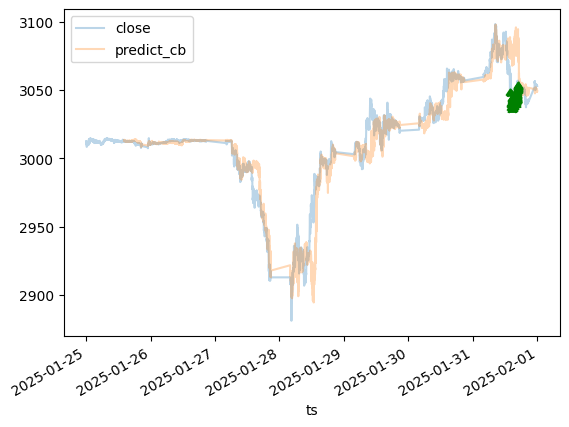

In [83]:
def is_cb_entry(asset, dt, take_profit: float = 0.05, comission: float = 0.0004):
    data = asset.get(dt)

    if data is None: 
        return False

    if "predict_cb" not in data:
        return False

    if data["predict_cb"] is None:
        return False

    if data["predict_cb"] >= data["close"] * (1 + comission * 2 + take_profit):
        return True

    return False

    
featurizer = FuncFeaturizer("entry_predict_cb", partial(is_cb_entry, take_profit=0.01), add_to_asset=True)
_ = featurizer.get_features_batch(asset)

dd = (
    asset.to_polars()
    .select("ts", "close", "entry_predict_cb", "predict_cb")
    .to_pandas()
)

ax = dd.set_index("ts")[["close", "predict_cb"]].plot(alpha=0.3)

entry_ts = dd.query("entry_predict_cb")["ts"]

ax.scatter(entry_ts, dd.query("entry_predict_cb")["close"], color="green", zorder=1000, marker=mpl_markers.CARETUP)

## linear

In [84]:
from src.features.models.linear import LinearModelPredictPriceFeaturizer

featurizer = LinearModelPredictPriceFeaturizer(
    name="predict_linear", 
    model_features=model_features, 
    target_col='close', 
    add_to_asset=True, 
    n_lags=500, 
    lag_target=120,
)

_ = featurizer.get_features_batch(asset)

asset.to_polars()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6830/6830 [00:35<00:00, 191.48it/s]


open,high,low,close,volume,ts,instrument_id,parse_ts,lot,sma_15,sma_30,sma_60,sma_120,rsi,sma_15_lag_5,sma_30_lag_5,sma_60_lag_5,sma_120_lag_5,close_lag_1,volume_lag_1,close_lag_5,volume_lag_5,close_lag_15,volume_lag_15,diff_sma_15_sma_15_lag_5,diff_sma_30_sma_30_lag_5,diff_sma_60_sma_60_lag_5,diff_sma_120_sma_120_lag_5,diff_volume_lag_5_volume_lag_1,diff_close_lag_5_close_lag_1,predict_cb,entry_predict_cb,predict_linear
f64,f64,f64,f64,i64,"datetime[μs, UTC]",str,datetime[μs],i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,i64,f64,i64,f64,f64,f64,f64,i64,f64,f64,bool,f64
3012.4,3012.4,3012.4,3012.4,3,2025-01-25 00:02:00 UTC,"""87db07bc-0e02-4e29-90bb-05e8ef…",2025-02-03 22:04:28.851341,1,NaN,NaN,NaN,NaN,NaN,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,false,null
3012.4,3012.4,3012.4,3012.4,5,2025-01-25 00:04:00 UTC,"""87db07bc-0e02-4e29-90bb-05e8ef…",2025-02-03 22:04:28.851341,1,NaN,NaN,NaN,NaN,NaN,null,null,null,null,3012.4,3,null,null,null,null,null,null,null,null,null,null,null,false,null
3010.0,3010.0,3010.0,3010.0,1,2025-01-25 00:05:00 UTC,"""87db07bc-0e02-4e29-90bb-05e8ef…",2025-02-03 22:04:28.851341,1,NaN,NaN,NaN,NaN,NaN,null,null,null,null,3012.4,5,null,null,null,null,null,null,null,null,null,null,null,false,null
3012.4,3012.6,3012.4,3012.6,7,2025-01-25 00:06:00 UTC,"""87db07bc-0e02-4e29-90bb-05e8ef…",2025-02-03 22:04:28.851341,1,NaN,NaN,NaN,NaN,NaN,null,null,null,null,3010.0,1,null,null,null,null,null,null,null,null,null,null,null,false,null
3012.6,3012.6,3012.6,3012.6,5,2025-01-25 00:08:00 UTC,"""87db07bc-0e02-4e29-90bb-05e8ef…",2025-02-03 22:04:28.851341,1,NaN,NaN,NaN,NaN,NaN,null,null,null,null,3012.6,7,null,null,null,null,null,null,null,null,null,null,null,false,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
3053.6,3053.8,3053.6,3053.8,11,2025-01-31 23:52:00 UTC,"""87db07bc-0e02-4e29-90bb-05e8ef…",2025-02-03 22:04:28.851341,1,3053.64,3052.993333,3050.5,3045.963333,56.941962,3053.533333,3053.06,3049.446667,3045.59,3053.8,20,3053.4,14,3052.4,1,0.106667,-0.066667,1.053333,0.373333,-6,-0.4,3049.381041,false,3049.173783
3053.6,3053.8,3053.6,3053.8,34,2025-01-31 23:53:00 UTC,"""87db07bc-0e02-4e29-90bb-05e8ef…",2025-02-03 22:04:28.851341,1,3053.693333,3053.013333,3050.723333,3046.043333,56.941962,3053.546667,3052.98,3049.663333,3045.65,3053.8,11,3053.4,16,3052.2,35,0.146667,0.033333,1.06,0.393333,5,-0.4,3049.019715,false,3048.990332
3053.8,3053.8,3053.8,3053.8,47,2025-01-31 23:54:00 UTC,"""87db07bc-0e02-4e29-90bb-05e8ef…",2025-02-03 22:04:28.851341,1,3053.706667,3053.04,3050.936667,3046.138333,57.401779,3053.52,3052.933333,3049.866667,3045.725,3053.8,34,3053.6,1,3053.8,15,0.186667,0.106667,1.07,0.413333,-33,-0.2,3048.604291,false,3048.865984


## Dumb

In [86]:
from src.features.models.base import DumbRegressionModelFeaturizer


featurizer = DumbRegressionModelFeaturizer(
    name="predict_dumb_regression", 
    model_features=model_features, 
    target_col='close', 
    add_to_asset=True, 
    n_lags=1000, 
    lag_target=60 * 4,
    model_params={
        "iterations": 50,
        "random_state": 32,
        "verbose": 0,
    },
)

_ = featurizer.get_features_batch(asset)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6830/6830 [00:27<00:00, 252.21it/s]


In [87]:
from src.features.models.base import DumbClassificationModelFeaturizer


featurizer = DumbClassificationModelFeaturizer(
    name="predict_dumb_clf", 
    model_features=model_features, 
    target_col='close', 
    add_to_asset=True, 
    n_lags=1000, 
    lag_target=60 * 4,
    min_up_perc=0.005,
    model_params={
        "iterations": 50,
        "random_state": 32,
        "verbose": 0,
    },
    use_time_weights=True,
)

_ = featurizer.get_features_batch(asset)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6830/6830 [00:31<00:00, 213.97it/s]


## cb classifier

In [88]:
from src.features.models.cb import CatboostClassifierFeaturizer

featurizer = CatboostClassifierFeaturizer(
    name="predict_cb_clf", 
    model_features=model_features, 
    target_col='close', 
    add_to_asset=True, 
    n_lags=1000, 
    lag_target=60 * 4,
    min_up_perc=0.005,
    model_params={
        "iterations": 50,
        "random_state": 32,
        "verbose": 0,
    },
    use_time_weights=True,
)

_ = featurizer.get_features_batch(asset)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6830/6830 [05:12<00:00, 21.87it/s]


In [89]:
featurizer = CatboostClassifierFeaturizer(
    name="predict_cb_clf_price_down", 
    model_features=model_features, 
    target_col='close', 
    add_to_asset=True, 
    n_lags=1000, 
    lag_target=60 * 4,
    min_up_perc=0.005,
    model_params={
        "iterations": 50,
        "random_state": 32,
        "verbose": 0,
    },
    predict_up=False,
    use_time_weights=True,
)

_ = featurizer.get_features_batch(asset)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6830/6830 [05:30<00:00, 20.69it/s]


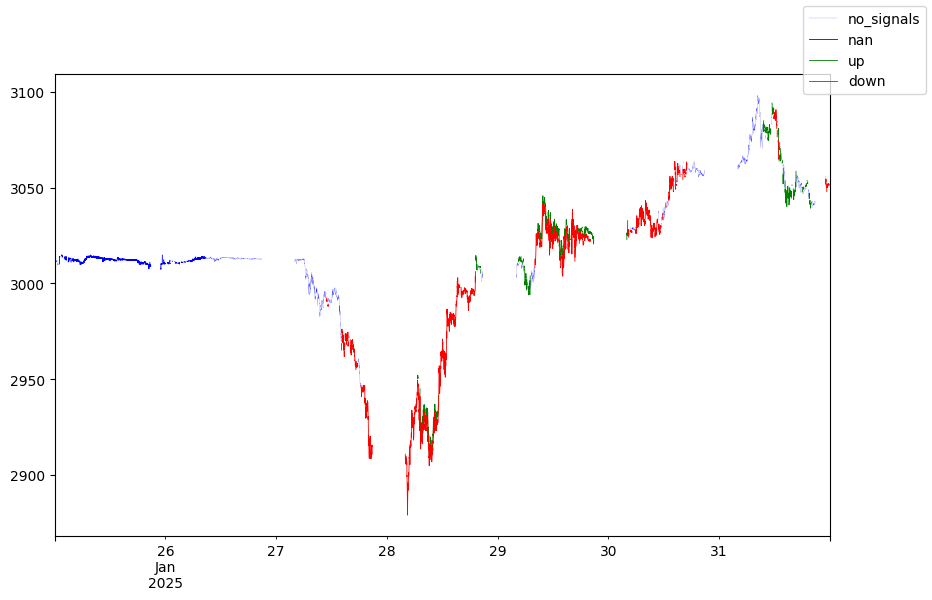

In [92]:
dd = (
    asset.to_polars()
    # .filter(pl.col("ts") >= datetime(2025, 1, 20, 0, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='UTC')))
    # .filter(pl.col("ts") <= datetime(2025, 1, 22, 0, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='UTC')))
    .select("ts", "close", "predict_cb_clf", "predict_cb_clf_price_down")
    .to_pandas()
    .set_index("ts")
)

index_df = pd.DataFrame(index=pd.date_range(dd.index.min(), dd.index.max(), freq="1min"))

nan_dd = dd.query("predict_cb_clf.isna()")
up_dd = dd.query("predict_cb_clf == 1")#.query("predict_cb_clf_price_down != 1")
down_dd = dd.query("predict_cb_clf_price_down == 1")#.query("predict_cb_clf != 1")
other_dd = dd.assign(flag=lambda x: 
(
    (x.predict_cb_clf != 1)
    & (x.predict_cb_clf_price_down != 1)
)).query("flag")

fig, ax = plt.subplots(figsize=(10, 6))
padding_price = 2

index_df.join(other_dd)["close"].plot(ax=ax, color="blue", label="no_signals", linewidth=0.1)
index_df.join(nan_dd)["close"].plot(ax=ax, color="blue", label="nan", linewidth=0.6)
(index_df.join(up_dd)["close"] + padding_price).plot(ax=ax, color="green", label="up", linewidth=0.6)
(index_df.join(down_dd)["close"] - padding_price).plot(ax=ax, color="red", label="down", linewidth=0.6)

fig.legend()

## logreg classifier

In [93]:
from src.features.models.linear import LogregClassifierFeaturizer

featurizer = LogregClassifierFeaturizer(
    name="predict_logreg_clf", 
    model_features=model_features, 
    target_col='close', 
    add_to_asset=True, 
    n_lags=1000, 
    lag_target=60 * 4,
    min_up_perc=0.005,
    use_time_weights=True,
)

_ = featurizer.get_features_batch(asset)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6830/6830 [01:26<00:00, 79.34it/s]


In [94]:
featurizer = LogregClassifierFeaturizer(
    name="predict_logreg_clf_price_down", 
    model_features=model_features, 
    target_col='close', 
    add_to_asset=True, 
    n_lags=1000, 
    lag_target=60 * 4,
    min_up_perc=0.005,
    use_time_weights=True,
    predict_up=False
)

_ = featurizer.get_features_batch(asset)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6830/6830 [01:29<00:00, 76.52it/s]


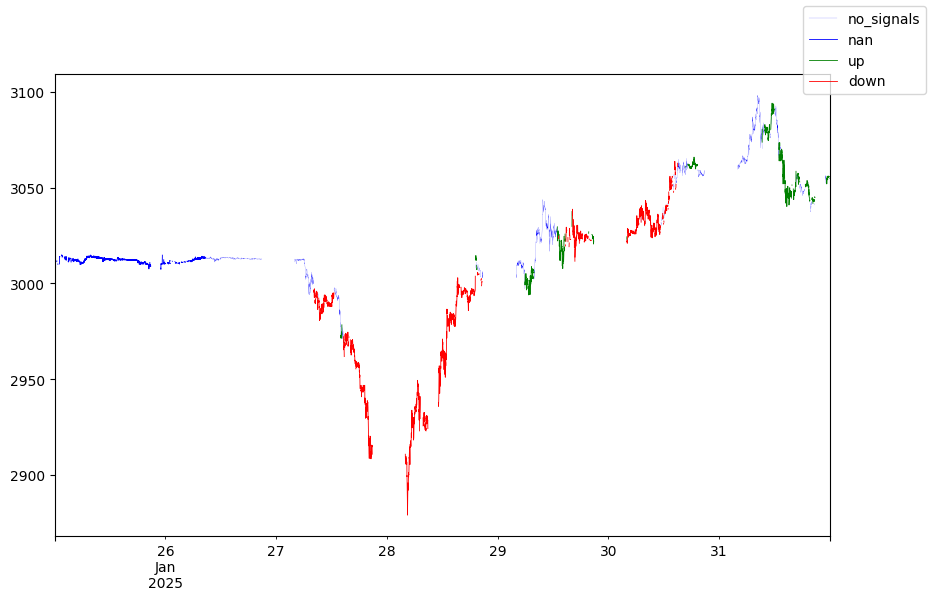

In [96]:
col_up = "predict_logreg_clf"
col_down = "predict_logreg_clf_price_down"

dd = (
    asset.to_polars()
    # .filter(pl.col("ts") >= datetime(2025, 1, 20, 0, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='UTC')))
    # .filter(pl.col("ts") <= datetime(2025, 1, 22, 0, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='UTC')))
    .select("ts", "close", col_up, col_down)
    .to_pandas()
    .set_index("ts")
)

index_df = pd.DataFrame(index=pd.date_range(dd.index.min(), dd.index.max(), freq="1min"))

nan_dd = dd.query(f"{col_up}.isna()")
up_dd = dd.query(f"{col_up} == 1").query(f"{col_down} != 1")
down_dd = dd.query(f"{col_down} == 1").query(f"{col_up} != 1")
other_dd = dd.assign(flag=lambda x: 
(
    (x[col_up] != 1)
    & (x[col_down] != 1)
)).query("flag")

fig, ax = plt.subplots(figsize=(10, 6))
padding_price = 2

index_df.join(other_dd)["close"].plot(ax=ax, color="blue", label="no_signals", linewidth=0.1)
index_df.join(nan_dd)["close"].plot(ax=ax, color="blue", label="nan", linewidth=0.6)
(index_df.join(up_dd)["close"] + padding_price).plot(ax=ax, color="green", label="up", linewidth=0.6)
(index_df.join(down_dd)["close"] - padding_price).plot(ax=ax, color="red", label="down", linewidth=0.6)

fig.legend()

# TALib

In [99]:
import talib
import numpy as np


prices = np.array([asset.data[dt][asset.open_col] for dt in asset.sorted_dates])
prices

array([3012.4, 3012.4, 3010. , ..., 3053.8, 3053.6, 3053. ])

In [136]:
featurizer = TALibFeaturizer("mm", func=lambda kwargs: talib.MA(real=kwargs["open"], timeperiod=2), add_to_asset=True)
output = featurizer.get_features_batch(asset)

6830it [00:00, 2339875.55it/s]


In [139]:
from tqdm.auto import tqdm


featurizer = TALibFeaturizer("mm2", func=lambda kwargs: talib.MA(real=kwargs["open"], timeperiod=2), add_to_asset=True)
for dt in tqdm(asset.sorted_dates):
    _ = featurizer.get_features_iter(asset, dt)
# output = featurizer.get_features_batch(asset)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6830/6830 [00:20<00:00, 340.91it/s]


In [140]:
asset.to_polars().select("ts", "open", "mm", "mm2")

ts,open,mm,mm2
"datetime[μs, UTC]",f64,f64,f64
2025-01-25 00:02:00 UTC,3012.4,null,null
2025-01-25 00:04:00 UTC,3012.4,NaN,NaN
2025-01-25 00:05:00 UTC,3010.0,3012.4,3012.4
2025-01-25 00:06:00 UTC,3012.4,3011.2,3011.2
2025-01-25 00:08:00 UTC,3012.6,3011.2,3011.2
…,…,…,…
2025-01-31 23:52:00 UTC,3053.6,3053.7,3053.7
2025-01-31 23:53:00 UTC,3053.6,3053.7,3053.7
2025-01-31 23:54:00 UTC,3053.8,3053.6,3053.6


In [130]:
np.arange(5)[:-1]

array([0, 1, 2, 3])

In [127]:
output[0][-3:]

[datetime.datetime(2025, 1, 31, 23, 54, tzinfo=zoneinfo.ZoneInfo(key='UTC')),
 datetime.datetime(2025, 1, 31, 23, 58, tzinfo=zoneinfo.ZoneInfo(key='UTC')),
 datetime.datetime(2025, 1, 31, 23, 59, tzinfo=zoneinfo.ZoneInfo(key='UTC'))]

In [128]:
output[1][0][-3:]

array([3053.7, 3053.7, 3053.3])

In [111]:
np.concatenate(([None, ], talib.MA(prices, 2)))

array([None, nan, 3012.4, ..., 3053.700000000008, 3053.700000000008,
       3053.300000000008], dtype=object)

In [102]:
prices.shape

(6830,)